Questions to answer about LSH

1. How to choose the number of hyperplanes? Does the Johnson-Lindenstrauss result apply?
2. How to efficiently hash new vectors?
3. How to test hashing without using elasticsearch?
4. Any other hyper-parameters?

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import numpy as np
import pdb

print('Done')

Done


Proportion positive at each hash:  0.5955
Recall @10 min, mean, median, max = 4.00, 6.94, 7.00, 10.00
[-3.76953295  0.15293201  4.07539698]


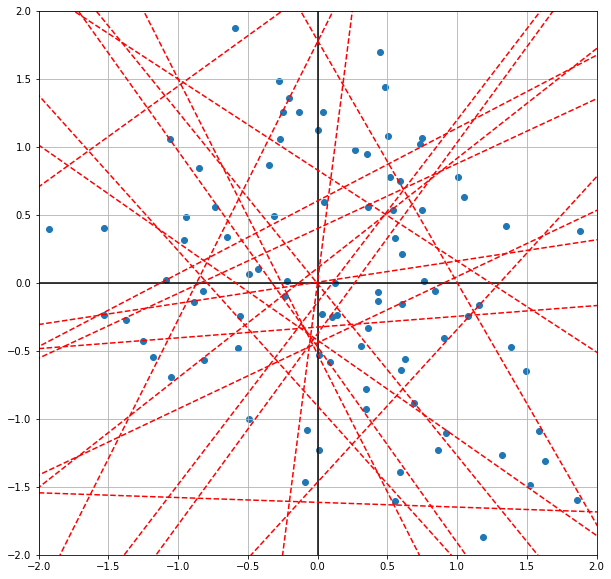

In [2]:
# This was a first pass at LSH, but it doesn't handle the case where points are not centered at (0, 0)..
# The implementation further down handles this case nicely.
rng = np.random.RandomState(22)

# Generate random points in 2D space.
X = rng.normal(0, 1, size=(100, 2))

# Sample random coefficients. In practice you probably don't know 
# the true distribution, so sample from the dataset. You might
# also benefit from adding some gaussian noise.
bits = 20
C = rng.choice(X.ravel(), size=(bits, X.shape[-1]))

# Compute bias.
# B = rng.normal(0, 2, size=bits)
B = rng.choice(X.ravel(), size=(bits,))

# Hash the points.
H = ((X.dot(C.T) + B) >= 0).astype(np.uint8)

# Value closer to 0.5 are good here..
print('Proportion positive at each hash: ', H.mean())

# Compute the recall @ 10...
knn = NearestNeighbors(n_neighbors=10, algorithm='brute', metric='euclidean')
nbrs_true = knn.fit(X).kneighbors(X, return_distance=False)
nbrs_hash = knn.fit(H).kneighbors(H, return_distance=False)

recalls = np.array([len(np.intersect1d(a, b)) for a, b in zip(nbrs_true, nbrs_hash)])
print('Recall @10 min, mean, median, max = %.2lf, %.2lf, %.2lf, %.2lf' % (
    recalls.min(), recalls.mean(), np.median(recalls), recalls.max()))

# Begin plotting...
plt.figure(figsize=(10,10))
plt.grid(True)
plt.axvline(0, color='k')
plt.axhline(0, color='k')

# Plot the line created by each pair of coefficients.
# This converts 0 = c0x0 + c1x1 + b to x1 = (c0x0 + b) / c1.
# There's likely a much more efficient way to do it...
lineX = np.linspace(X.min() - 1, X.max() + 1, 3)
print(lineX)
for i in range(bits):
    c0, c1 = C[i]
    b = B[i]
    y = ((c0 * lineX) + b) / (c1 + 1e-7)
    plt.plot(lineX, y, color='r', linestyle='--')

plt.scatter(X[:, 0], X[:, 1])
plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.show()

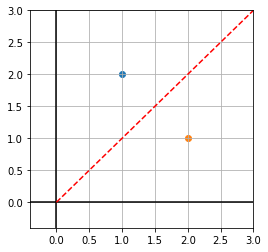

In [3]:
# Find the plane equidistant to two points.
# Example in two dimensions for plotting, but it generalizes to higher dimensions.
# Good explanation/refresher: https://www.youtube.com/watch?v=5UHRqkUMjKk

# 2 points.
p, q = np.array((1, 2)), np.array((2, 1))

# Midpoint
m = (p + q) / 2

# Normal vector.
n = m - q

plt.figure(figsize=(4,4))
plt.grid(True)
plt.axvline(0, color='k')
plt.axhline(0, color='k')
plt.xlim(-0.4, 3)
plt.ylim(-0.4, 3)
plt.scatter(*p)
plt.scatter(*q)

# 0 = n0x0 + n1x1 - n0m0 - n1m1
#   = n0x0 + n1x1 - (n0m0 + n1m1)
#   = nx - nm  (<--- "n dot x" minus "n dot m")
X = np.vstack([np.linspace(0, 3, 3), np.zeros(3)]).T
X[:,1] = (n[0] * X[:,0] - n.dot(m)) / (-1 * n[1])

plt.plot(X[:,0], X[:,1], color='red', linestyle='--')
plt.show()

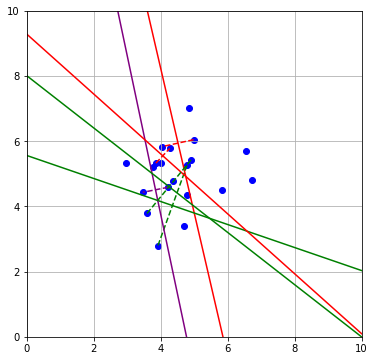

In [4]:
# Pick the LSH planes by randomly sampling pairs of points and computing the equidistant plane between them.
# This accounts for the fact that the points are not always centered around zero.
from itertools import cycle
colors = cycle(['red', 'green', 'purple'])
plt.figure(figsize=(6, 6))
plt.xlim(0, 10)
plt.ylim(0, 10)
plt.grid(True)

# Generate random points in 2D space.
rng = np.random.RandomState(33)
X = rng.normal(5, 1, size=(20, 2))

bits = 5
ii = rng.choice(np.arange(len(X)), size=(bits, 2), replace=False)
for i0, i1 in ii:
    p, q = X[i0], X[i1]
    
    c = next(colors)
    plt.plot([p[0], q[0]], [p[1], q[1]], color=c, linestyle='--')
    
    # This is effectively the only information that needs to be stored.
    m = (p + q) / 2 # Midpoint.
    n = m - q       # Normal vector.
    
    # Some arithmetic to plot the lines.
    Z = np.vstack([np.linspace(0, 10, 2), np.zeros(2)]).T
    Z[:,1] = (n[0] * Z[:,0] - n.dot(m)) / (-1 * n[1])
    plt.plot(Z[:,0], Z[:,1], color=c, linestyle='-')
    

plt.scatter(X[:, 0], X[:, 1], color='blue')
plt.show()

In [6]:
# Packaging up the above implementation in a scikit-learn-style class.

class SimpleLSH(object):
    def __init__(self, seed=865, bits=32):
        self.rng = np.random.RandomState(seed)
        self.bits = bits
        self.M = None
        self.N = None
        self.NdotM = None
    
    def fit(self, X):
        
        # Fit by picking *bits* pairs of points and computing the planes equidistant between them.
        X_sample = self.rng.choice(X.ravel(), size=(2, self.bits, X.shape[-1]))
        
#         plt.scatter(X[:, 0], X[:, 1], color='red')
#         for i in range(bits):
#             plt.plot([X_sample[0, i, 0], X_sample[1, i, 0]], 
#                      [X_sample[0, i, 1], X_sample[1, i, 1]], color='gray')
#         plt.scatter(X_sample[0, :, 0], X_sample[0, :, 1], color='green')
#         plt.scatter(X_sample[1, :, 0], X_sample[1, :, 1], color='blue')
        
        # Midpoints for each pair of points.
        M = (X_sample[0, ...] + X_sample[1, ...]) / 2.
        
#         plt.scatter(M[:, 0], M[:, 1], color='k', marker='x')
#         plt.title('Fitting...')
#         plt.show()
        
        # Normal vector for each pair of points.
        N = X_sample[-1 ,...] - M
        
        # Keep them around for later.
        self.M = M
        self.N = N
        self.NdotM = (N * M).sum(-1)
        
        return self
    
    def get_hash(self, X):
        XdotN = X.dot(self.N.T)
#         S = XdotN - self.NdotM
#         return (S >= 0).astype(np.uint8)
        H = (XdotN >= self.NdotM).astype(np.uint8)
        return H
        

def eval_recall(X, X_hash, k=10):
    knn = NearestNeighbors(n_neighbors=k, metric='euclidean', algorithm='brute')
    nbrs = knn.fit(X).kneighbors(X, return_distance=False)
    knn = NearestNeighbors(n_neighbors=k, metric='hamming', algorithm='brute')
    nbrs_hash = knn.fit(X_hash).kneighbors(X_hash, return_distance=False)
    recalls = [len(np.intersect1d(n, nh)) for n, nh in zip(nbrs, nbrs_hash)]
    return recalls

np.random.seed(11)
X = np.random.normal(6, 1, size=(1000, 15))
print('Experiment with random normal vectors, shape %s' % (str(X.shape)))

for exp in range(2, 11):
    bits = 2 ** exp
    lsh = SimpleLSH(seed=1, bits=bits).fit(X)
    X_hash = lsh.get_hash(X)
    print('Median recall @ 10, using %d bits = %d' % (bits, np.median(eval_recall(X, X_hash))))

Experiment with random normal vectors, shape (1000, 15)
Median recall @ 10, using 4 bits = 0
Median recall @ 10, using 8 bits = 1
Median recall @ 10, using 16 bits = 2
Median recall @ 10, using 32 bits = 3
Median recall @ 10, using 64 bits = 4
Median recall @ 10, using 128 bits = 5
Median recall @ 10, using 256 bits = 6
Median recall @ 10, using 512 bits = 7
Median recall @ 10, using 1024 bits = 7


In [10]:
X = np.load('../es-lsh-images/imagenet_vectors.npy')
print('Experiment with ImageNet vectors, shape %s' % (str(X.shape)))

for exp in range(4, 12):
    bits = 2 ** exp
    lsh = SimpleLSH(seed=1, bits=bits).fit(X)
    X_hash = lsh.get_hash(X)
    print('Median recall @ 10, using %d bits = %d' % (bits, np.median(eval_recall(X, X_hash))))

Experiment with ImageNet vectors, shape (5500, 2048)
Median recall @ 10, using 16 bits = 1
Median recall @ 10, using 32 bits = 1
Median recall @ 10, using 64 bits = 2
Median recall @ 10, using 128 bits = 3
Median recall @ 10, using 256 bits = 4
Median recall @ 10, using 512 bits = 5
Median recall @ 10, using 1024 bits = 6
Median recall @ 10, using 2048 bits = 7


In [12]:
X = np.load('../es-lsh-images/twitter_vectors.npy')[:6000, :]
print('Experiment with Twitter vectors, shape %s' % (str(X.shape)))

for exp in range(8, 11):
    bits = 2 ** exp
    lsh = SimpleLSH(seed=1, bits=bits).fit(X)
    X_hash = lsh.get_hash(X)
    print('Median recall @ 10, using %d bits = %d' % (bits, np.median(eval_recall(X, X_hash))))

Experiment with Twitter vectors, shape (6000, 2048)
Median recall @ 10, using 256 bits = 3
Median recall @ 10, using 512 bits = 4
Median recall @ 10, using 1024 bits = 5
